(lgm-prelims-notebook)=
# Considerazioni Preliminari

In questo capitolo esamineremo alcune questioni pratiche e preliminari relative all'organizzazione di dati che provengono da studi longitudinali

In [1]:
source("../_common.R")
suppressPackageStartupMessages({
    library("DT")
    library("kableExtra")
    library("lme4")
    library("JWileymisc")
    library("multilevelTools")
    library("data.table")
    library("insight")
})

## Strutture dei dati

Tradizionalmente, gli studi longitudinali venivano condotti con un numero relativamente basso di valutazioni ripetute (meno di 8) e un numero elevato di individui (più di 200). Tuttavia, i progressi nelle teorie statistica, che includono l'utilizzo di modelli non lineari, e nella tecnologia di raccolta dati, come i sondaggi basati sul web e gli smartphone, hanno notevolmente ampliato le possibilità di raccogliere e analizzare dati longitudinali. In particolare, {cite:t}`grimm2016growth` hanno discusso l'applicazione di modelli di crescita latente a dati longitudinali di grandi dimensioni, comprendenti fino a 50,000 individui e 1,000 valutazioni ripetute.

### Formato Long e Wide

I dati longitudinali tipicamente si presentano in due forme: *long* e *wide*. Nel formato *long*, la descrizione del tempo è sulle righe; nel formato *wide* le variabili relative ad ogni occasione temporale sono organizzate in colonne. È possibile trasformere i dati dal formato *long* in formato *wide* e viceversa usando le funzioni R `pivot_wider()` e `pivot_longer()`. La sintassi è spiegata nella pagina web [tidyr](https://tidyr.tidyverse.org/reference/pivot_wider.html).

Per fare un esempio, esaminiamo il cambiamento nel rendimento in matematica dei bambini durante la scuola elementare e media utilizzando il set di dati NLSY-CYA. Questi dati sono stati analizzati da {cite:p}`grimm2016growth` e possono essere utilizzati per illustrare i concetti relativi alle analisi di cambiamento longitudinale.

Iniziamo a leggere i dati in `R`.

In [2]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_long_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_long <- dat

# Add names the columns of the data set
names(nlsy_math_long) <- c(
  "id", "female", "lb_wght",
  "anti_k1", "math", "grade",
  "occ", "age", "men",
  "spring", "anti"
)

# view the first few observations in the data set
head(nlsy_math_long) |> 
print()

    id female lb_wght anti_k1 math grade occ age men spring anti
1  201      1       0       0   38     3   2 111   0      1    0
2  201      1       0       0   55     5   3 135   1      1    0
3  303      1       0       1   26     2   2 121   0      1    2
4  303      1       0       1   33     5   3 145   0      1    2
5 2702      0       0       0   56     2   2 100  NA      1    0
6 2702      0       0       0   58     4   3 125  NA      1    2


I dati sono qui forniti nel formato *long*. 

Contiamo il numero di partecipanti.

In [3]:
nlsy_math_long |>
  distinct(id) |>
  count() |> 
  print()

    n
1 932


Con `pivot_wider` possiamo trasformare i dati in formato *wide*.

In [4]:
nlsy_math_wide <- nlsy_math_long |> 
  pivot_wider(names_from = grade, values_from = math)

nlsy_math_wide |>
  head() |> 
  print()

# A tibble: 6 × 16
     id female lb_wght anti_k1   occ   age   men spring  anti   `3`   `5`   `2`
  <int>  <int>   <int>   <int> <int> <int> <int>  <int> <int> <int> <int> <int>
1   201      1       0       0     2   111     0      1     0    38    NA    NA
2   201      1       0       0     3   135     1      1     0    NA    55    NA
3   303      1       0       1     2   121     0      1     2    NA    NA    26
4   303      1       0       1     3   145     0      1     2    NA    33    NA
5  2702      0       0       0     2   100    NA      1     0    NA    NA    56
6  2702      0       0       0     3   125    NA      1     2    NA    NA    NA
# ℹ 4 more variables: `4` <int>, `8` <int>, `6` <int>, `7` <int>


## Visualizzazione dei dati longitudinali

Come in qualsiasi analisi statistica, è importante esaminare attentamente i dati. Ciò include la produzione di sia riepiloghi quantitativi che visualizzazioni. Per fare un esempio di visualizzazione di dati longitudinali, esaminiamo il cambiamento nel rendimento in matematica dei bambini durante la scuola elementare e media utilizzando il set di dati NLSY-CYA [si veda {cite:t}`grimm2016growth`]. Da questi dati, selezioniamo solo il grado scolastico, il codice identificativo e il punteggio di matematica.

In [5]:
nlsy_math_only_long <- nlsy_math_long |>
    dplyr::select(id, grade, math)

Le traiettorie di cambiamento intra-individuale possono essere prodotte nel modo seguente.

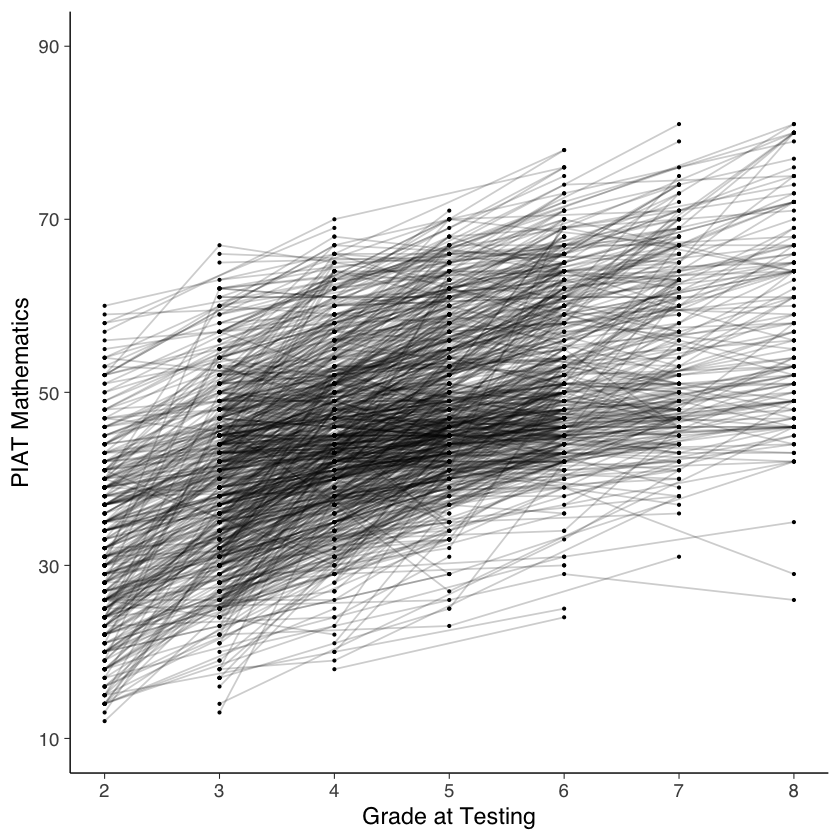

In [6]:
nlsy_math_long |> # data set
  ggplot(aes(x = grade, y = math, group = id)) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line(alpha=0.2) + # adding lines to plot
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "PIAT Mathematics"
  )

Esaminiamo le traiettorie di sviluppo dei primi 9 partecipanti.

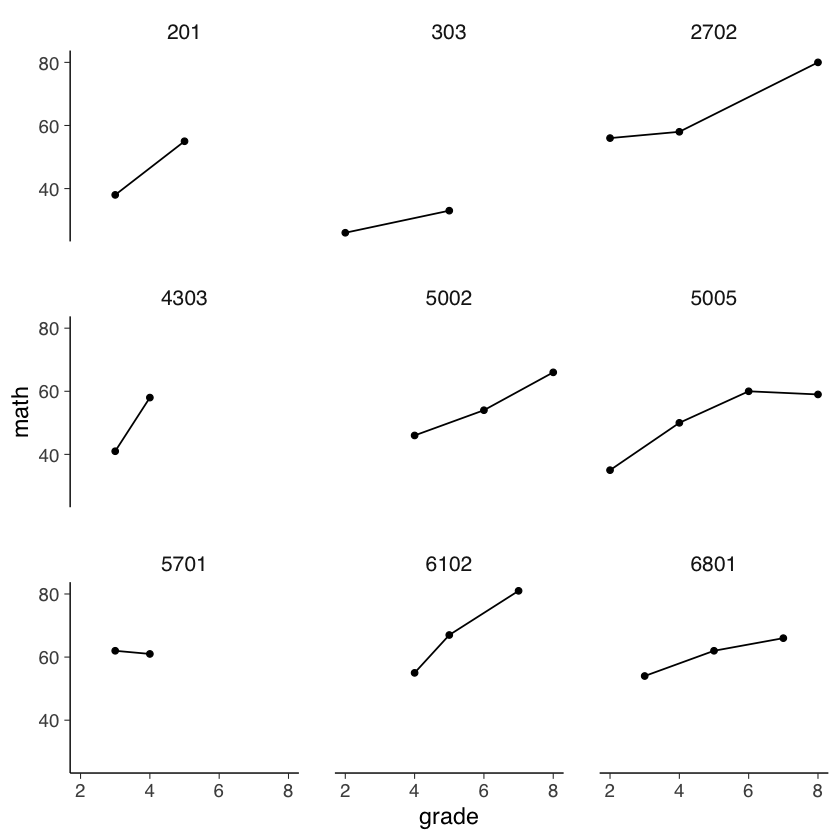

In [7]:
subset_it <- c(201, 303, 2702, 4303, 5002, 5005, 5701, 6102, 6801)
temp <- nlsy_math_long[nlsy_math_long$id %in% subset_it, ]

temp %>%
  ggplot(aes(x = grade, y = math)) +
  geom_point() +
  geom_line() +
  # coord_cartesian(ylim = c(1, 4)) +
  theme(panel.grid = element_blank()) +
  facet_wrap(~id)

## Data screening

Prima di adattare i modelli di crescita ai dati longitudinali, è essenziale effettuare una valutazione preliminare dei dati e acquisire informazioni di base sulle variabili da utilizzare nell'analisi. Una delle prime fasi di questa valutazione preliminare è l'ispezione della distribuzione dei punteggi per ogni variabile, utilizzando le principali statistiche descrittive univariate, come la media, la mediana, la varianza (deviazione standard), l'asimmetria, la curtosi, il minimo, il massimo, l'intervallo e il numero di osservazioni per ogni variabile, in base alla metrica del tempo scelta. Le statistiche descrittive bivariate, come le correlazioni/covarianze e le tabelle di frequenza bivariate per variabili nominali o ordinali, possono fornire informazioni sui possibili schemi e relazioni non lineari, nonché sui potenziali valori anomali e codici errati.

I dati longitudinali sono caratterizzati dall'ordinamento dei dati lungo una o più metriche del tempo (ad esempio, l'occasione di misurazione, l'età, la data, il tempo dall'evento, il numero di esposizioni, ecc.). È importante esaminare come la media, la varianza e il numero di casi disponibili cambiano attraverso le misure ripetute (ad esempio wght5, wght6, wght7). Va notato che la selezione della metrica del tempo influisce notevolmente sulla capacità di interpretare i risultati di qualsiasi modello di crescita specifico. Pertanto, durante la fase di selezione dei dati, è necessario considerare attentamente come varie proprietà dei dati longitudinali cambiano quando i dati sono organizzati in relazione a diverse metriche del tempo.

Per i dati dell'esempio, le statistiche descrittive possono essere ottenute nel modo seguente.

In [8]:
describe(nlsy_math_long) |>
    print()

        vars    n      mean        sd median   trimmed       mad min     max
id         1 2221 528449.15 327303.70 497403 515466.90 384144.63 201 1256601
female     2 2221      0.49      0.50      0      0.49      0.00   0       1
lb_wght    3 2221      0.08      0.27      0      0.00      0.00   0       1
anti_k1    4 2221      1.42      1.50      1      1.19      1.48   0       8
math       5 2221     46.12     12.80     46     46.22     11.86  12      81
grade      6 2221      4.51      1.77      4      4.44      1.48   2       8
occ        7 2221      2.84      0.79      3      2.77      1.48   2       5
age        8 2221    126.90     22.06    126    126.28     25.20  82     175
men        9 1074      0.19      0.40      0      0.12      0.00   0       1
spring    10 2221      0.65      0.48      1      0.69      0.00   0       1
anti      11 2170      1.58      1.54      1      1.38      1.48   0       8
          range  skew kurtosis      se
id      1256400  0.30    -0.90 6945.0

Esaminiamo le statistiche descrittive bivariate.

In [9]:
cor(nlsy_math_long, use='pairwise.complete.obs') |> 
  round(2) |> 
  print()

           id female lb_wght anti_k1  math grade   occ   age   men spring  anti
id       1.00  -0.01   -0.01   -0.02 -0.22 -0.01  0.01 -0.01 -0.02  -0.11  0.01
female  -0.01   1.00    0.06   -0.09 -0.05  0.00 -0.02 -0.04  0.02   0.04 -0.07
lb_wght -0.01   0.06    1.00    0.03 -0.03 -0.02 -0.03  0.01  0.04   0.03  0.02
anti_k1 -0.02  -0.09    0.03    1.00 -0.08 -0.03 -0.04 -0.01  0.01  -0.01  0.52
math    -0.22  -0.05   -0.03   -0.08  1.00  0.59  0.53  0.58  0.30   0.29 -0.05
grade   -0.01   0.00   -0.02   -0.03  0.59  1.00  0.87  0.95  0.62   0.12  0.04
occ      0.01  -0.02   -0.03   -0.04  0.53  0.87  1.00  0.86  0.57   0.17  0.04
age     -0.01  -0.04    0.01   -0.01  0.58  0.95  0.86  1.00  0.64   0.21  0.06
men     -0.02   0.02    0.04    0.01  0.30  0.62  0.57  0.64  1.00   0.16  0.13
spring  -0.11   0.04    0.03   -0.01  0.29  0.12  0.17  0.21  0.16   1.00 -0.01
anti     0.01  -0.07    0.02    0.52 -0.05  0.04  0.04  0.06  0.13  -0.01  1.00


Scomponiamo i punteggi nelle componenti tra i soggetti ed entro i soggetti.

Esaminiamo la distribuzione delle medie dei punteggi tra i soggetti.

In [10]:
tmp <- meanDecompose(math ~ id, data = nlsy_math_long)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's colour values.”


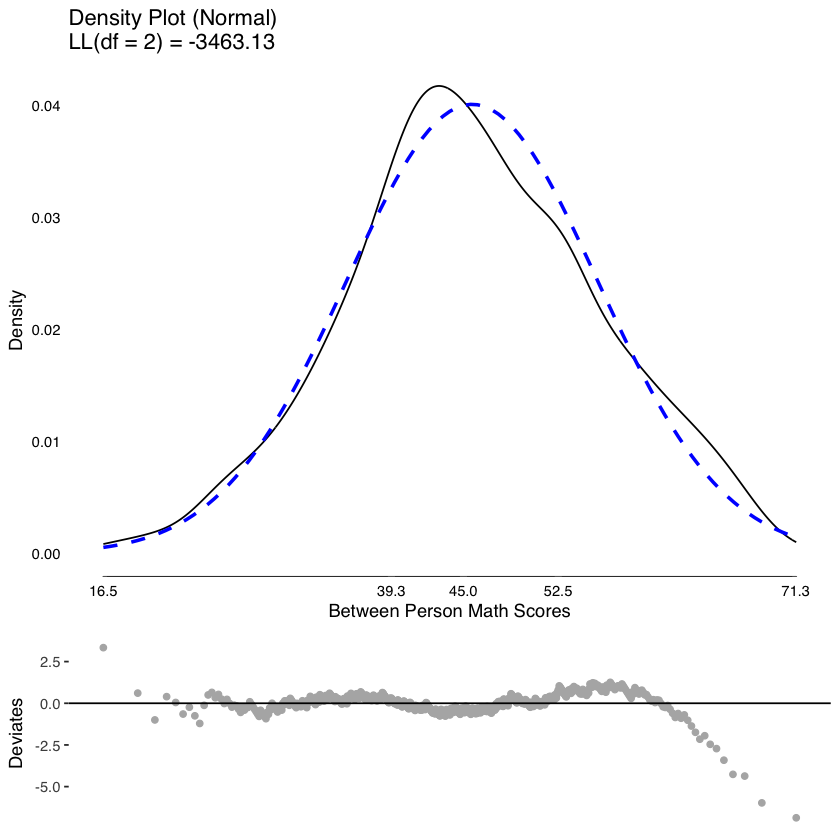

In [11]:
plot(
    testDistribution(
        tmp[["math by id"]]$X,
        extremevalues = "theoretical", ev.perc = .001
    ),
    varlab = "Between Person Math Scores"
)

Esaminiamo la distribuzione dei punteggi entro i soggetti.

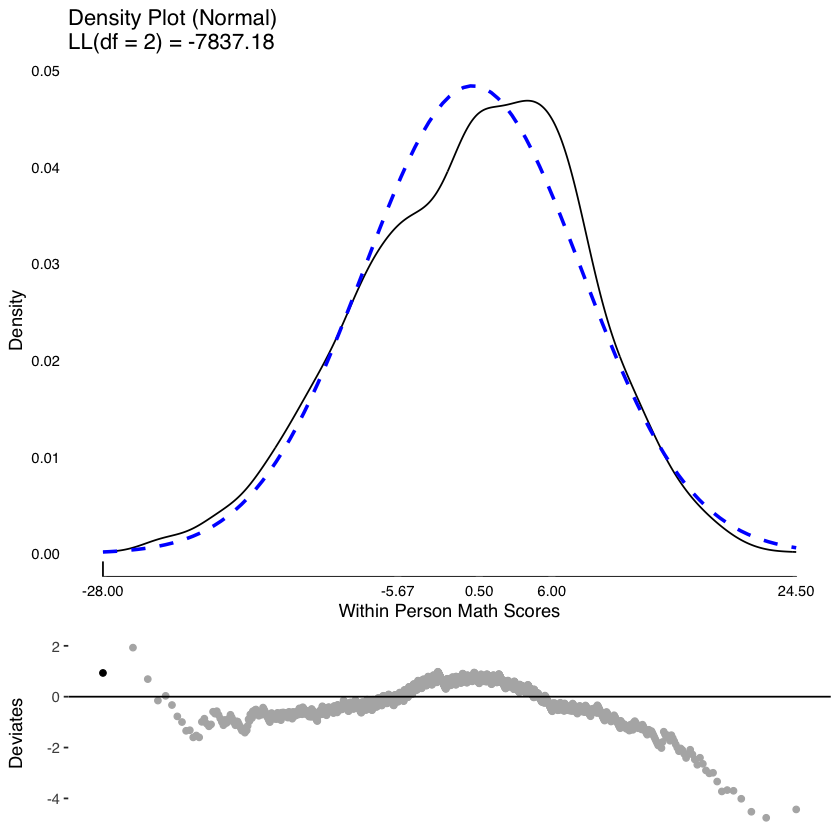

In [12]:
plot(
    testDistribution(
        tmp[["math by residual"]]$X,
        extremevalues = "theoretical", ev.perc = .001
    ),
    varlab = "Within Person Math Scores"
)

## Attendibilità

Per garantire la validità delle analisi, è necessario valutare l'affidabilità degli strumenti di misurazione utilizzati. Ciò è particolarmente importante in analisi longitudinali, in cui si studiano i cambiamenti all'interno di ciascun individuo nel tempo. Una delle metodologie utilizzate per valutare l'affidabilità degli strumenti di misurazione è il calcolo dell'indice di affidabilità $\omega$ di McDonald per ogni momento temporale in cui si effettua la misurazione. Tuttavia, è importante sottolineare che questo indice non è equivalente alle misure di affidabilità degli indici di cambiamento longitudinale. Quest'ultima è una problematica complessa, soprattutto in disegni longitudinali intensivi, e costituisce un tema di discussione nella letteratura metodologica contemporanea.

Mentre l'affidabilità dei cambiamenti intra-individuali è difficile da stimare, l'affidabilità delle differenze inter-individuali può essere trovata facilmente. L’affidabilità del cambiamento inter-individuale è la proporzione di varianza nei punteggi osservati tra gli individui che può essere attribuita alla varianza nei punteggi veri piuttosto che alla varianza dell’errore:

$$
\frac{\text{varianza di interesse}}{\text{varianza di interesse} + \text{varianza d'errore}},
$$

Nel caso delle misure di differenza individuale ottenute tramite *Intensive Longitudinal Designs* (ILD), per valutare l'affidabilità delle medie intra-individuali $\bar{y}$ (cioè la varianza "vera" delle medie tra i soggetti) si può utilizzare il coefficiente di correlazione intraclasse (ICC). In sostanza, l'ICC indica la proporzione di varianza totale che è attribuibile alle differenze tra gli individui rispetto alla varianza totale, che comprende sia le differenze tra gli individui che le differenze all'interno di ciascun individuo nel tempo. L'ICC viene calcolato come un rapporto tra varianze:

$$
\rho^2_{\bar{y}} = \frac{\hat{\tau}^2_{\mu}}{\hat{\tau}^2_{\mu} + \hat{\tau}^2_{\varepsilon}}.
$$

Il coefficiente di correlazione intraclasse (ICC) può essere stimato utilizzano un modello misto lineare con intercetta casuale che tiene conto della clusterizzazione dei dati, cioè del fatto che le osservazioni sono raggruppate in base ai soggetti. L'ICC viene calcolato come il rapporto tra la varianza tra le medie dei cluster di raggruppamento dei dati e la varianza totale, che comprende la varianza tra i cluster e la varianza all'interno dei cluster. In altre parole, l'ICC rappresenta la proporzione di varianza totale che è dovuta alle differenze tra i soggetti rispetto alla varianza totale delle misure ripetute. Questo indice è utile per valutare l'affidabilità delle misure ripetute e la loro utilità per lo studio delle differenze individuali.

Un esempio concreto può aiutare a capire meglio il concetto. Consideriamo nuovamente i dati `nlsy_math_long`, che rappresentano il cambiamento nel rendimento in matematica dei bambini tra i gradi scolastici 2 e 8. 

Selezioniamo solo le variabili di interesse.

In [13]:
nlsy_math_only_long <- nlsy_math_long %>%
    dplyr::select(id, grade, math)

nlsy_math_only_long |>
    head()|> 
    print()

    id grade math
1  201     3   38
2  201     5   55
3  303     2   26
4  303     5   33
5 2702     2   56
6 2702     4   58


Il coefficiente ICC può essere trovato, ad esempio, mediante la funzione `iccMixed` specificando un raggruppamento dei dati nei termini dei soggetti. 

In [14]:
iccMixed(
  dv = "math",
  id = c("id"),
  data = nlsy_math_long
) |>
  print()

        Var     Sigma       ICC
     <char>     <num>     <num>
1:       id  47.02036 0.2872289
2: Residual 116.68307 0.7127711


Per capire meglio il significato dell'ICC calcolato in precedenza per i dati `nlsy_math_long`, possiamo replicare lo stesso risultato utilizzando il modello misto lineare `lmer`, che tiene conto dell'effetto casuale del soggetto. In questo modo, possiamo avere una stima della varianza intraclasse e quindi dell'ICC.

In [15]:
m <- lmer(math ~ 1 + (1 | id), data = nlsy_math_only_long)

Il modello misto decompone la varianza totale in due componenti: la varianza che dipende dalla differenze tra le medie di ciascun soggetto (tra i soggetti, o varianza delle intercette individuali, $\tau_{00}$) e la varianza che dipende dalle variazioni di ciascun soggetto attorno alla sua media.

Calcoliamo la varianza totale dei punteggi di matematica.

In [16]:
var(nlsy_math_only_long$math) |>
    print()

[1] 163.8379


Esaminiamo ora la scomposizione della varianza eseguita dal modello misto. Si noti che la somma delle due componenti è uguale alla varianza totale.

In [17]:
VarCorr(m) |>
    print()

 Groups   Name        Std.Dev.
 id       (Intercept)  6.8571 
 Residual             10.8020 


In [18]:
6.8571^2 + 10.8020^2

[1] 163.703

Il coefficiente ICC è data dal rapporto tra la varianza attribuibile alla variazione tra le medie dei soggetti e la varianza totale.

In [19]:
6.8571^2 / (6.8571^2 + 10.8020^2)

[1] 0.2872263

In ambito di modelli LGM, l'ICC può essere utilizzato per stimare l'affidabilità delle medie intra-individuali dei fattori latenti, ma non è applicabile per l'affidabilità delle variazioni intra-individuali delle traiettorie di sviluppo. Per queste ultime, altre misure di affidabilità sono necessarie e hanno alcune limitazioni pratiche. Ad esempio, il coefficiente di affidabilità test-retest può essere utilizzato per stimare l'affidabilità intra-individuale delle traiettorie di sviluppo calcolate in due momenti temporali diversi, ma richiede l'assunzione che i punteggi veri non cambino nel tempo. In alternativa, le forme parallele dei test possono essere utilizzate per misurare l'affidabilità delle traiettorie intra-individuali, ma queste non sono sempre disponibili. Per stimare l'affidabilità della componente sistematica della variazione intra-individuale delle traiettorie di sviluppo, sono necessari metodi di stima specifici che sono ancora oggetto di dibattito nella letteratura metodologica corrente.

Prima di descrivere in dettaglio i modelli LGM, consideramo l'analisi dei dati longitudinali con i modelli misti. In R, queste analisi vengono svolte mediante la funzione `lmer` del pacchetto `lme4`.

### Analisi con `lmer`

La funzione `lmer()` accetta i seguenti argomenti:

- formula: una formula lineare a due lati che descrive sia gli effetti fissi che gli effetti casuali del modello, con la risposta a sinistra dell’operatore `~` e i predittori e gli effetti casuali sulla destra dell’operatore `~`. 
- data: Un data.frame, che deve essere nel cosiddetto formato “lungo”, con una singola riga per osservazione. 

Iniziamo a descrivere la sintassi che consente la specificazione di un modello misto. Gli effetti fissi sono specificati come segue.

| Formula	| Description |
| --------- | ----------- |
| `a + b`	| main effects of a and b (and no interaction) |
| `a:b`	| only interaction of a and b (and no main effects) |
| `a * b` |	main effects and interaction of a and b (expands to: a + b + a:b) |
| `(a+b+c)^2`	| main effects and two-way interactions, but no three-way interaction (expands to: `a + b + c + a:b + b:c + a:c`) |
| `(a+b)*c`	|all main effects and pairwise interactions between c and a or b (expands to: `a + b + c + a:c + b:c`) |
| `0 + a` | 0 suppresses the intercept resulting in a model that has one parameter per level of a (identical to: `a - 1`) |

Gli effetti random vengono aggiunti alla formula tra parentesi `()`. All’interno di queste parentesi si fornisce sul lato sinistro di un segno condizionale `|` la specifica degli effetti casuali relativi alle pendenze individuali da includere nel modello. Sul lato destro di questo segno condizionale, si specifica il fattore di raggruppamento o i fattori di raggruppamento da cui dipendono questi effetti casuali. I fattori di raggruppamento devono essere di classe `factor` (cioè non possono essere variabili numeriche).

Gli effetti random vengono specificati come segue.

| Formula	| Description |
| --------- | ----------- |
| `(1\|s)`	| random intercepts for unique level of the factor s |
| `(1\|s) + (1\|i)`	| random intercepts for each unique level of s and for each unique level of i |
| `(1\|s/i)`	| random intercepts for factor s and i, where the random effects for i are nested in s. This expands to `(1\|s) + (1\|s:i)` , i.e. a random intercept for each level of s, and each unique combination of the levels of s and i. Nested random effects are used in so-called multilevel models. For example, s might refer to schools, and i to classrooms within those schools. |
| `(a\|s)`	| random intercepts and random slopes for a, for each level of s. Correlations between the intercept and slope effects are also estimated -- identical to `(a*b\|s))` |
| `(a*b\|s)` |	random intercepts and slopes for a, b, and the a:b interaction, for each level of s. Correlations between all the random effects are estimated. |
| `(0+a\|s)`	| random slopes for a for each level of s, but no random intercepts |
| `(a\|\|s)` | random intercepts and random slopes for a, for each level of s, but no correlations between the random effects (i.e. they are set to 0). This expands to: `(0+a\|s) + (1\|s)` |

### Formulazione del modello

In precedenza abbiamo descritto la variazione media tra gli individui mediante un modello misto ad intercetta casuale. È possibile estendere questo modello a casi più complessi, per esempio quello che assume una retta di regressione con pendenza ed intercetta diversa per ciascun soggetto. Per i dati `nlsy_math_long` possiamo specificare un tale modello in `lmer` usando la sintassi seguente.

In [20]:
m <- lmer(math ~ grade + (1 + grade | id), data = nlsy_math_long)

In un modello misto, i coefficienti delle rette di regressione di ciascun soggetto sono considerati come componenti casuali di una distribuzione di coefficienti relativi all'intercetta e alla pendenza complessive del gruppo. Questi coefficienti casuali possono essere modellati specificando una componente casuale `(1 + grado | id)`. In questo tipo di modello, esiste una correlazione tra i parametri delle intercette e quelli delle pendenze individuali. Ciò significa che le componenti di varianza attribuibili ai vari effetti del modello (fissi e casuali) non sono più indipendenti e la varianza totale non può essere scomposta in componenti indipendenti.

Per estrarre le componenti di varianza di un modello misto, è possibile utilizzare le funzioni fornite dal pacchetto `insight`. Ad esempio, nel caso dell'esempio presentato, i risultati possono essere ottenuti attraverso l'oggetto creato dalla funzione `lmer`.

In [21]:
get_variance(m) |>
    print()

$var.fixed
[1] 58.94602

$var.random
[1] 70.66767

$var.residual
[1] 36.23643

$var.distribution
[1] 36.23643

$var.dispersion
[1] 0

$var.intercept
      id 
68.40554 

$var.slope
 id.grade 
0.7391598 

$cor.slope_intercept
        id 
-0.2353175 



Una descrizione visiva della varianza delle varie componenti del modello può essere ottenuta mediante la funzione `modelDiagnostics` del pacchetto `JWileymisc`.

Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's colour values.”


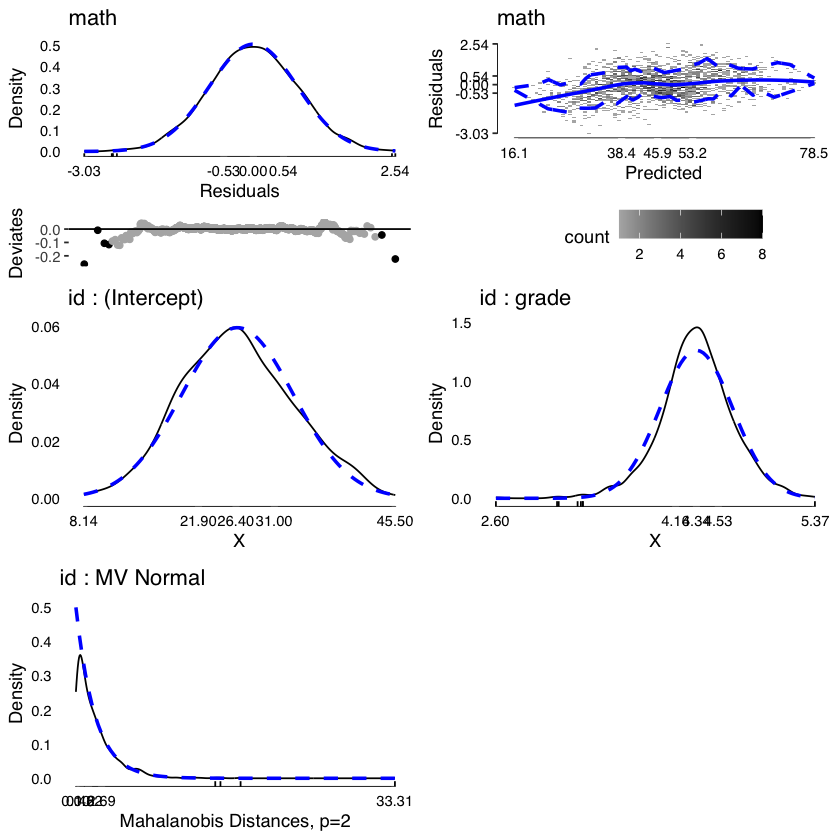

In [22]:
md <- modelDiagnostics(m, ev.perc = .001)
plot(md, ask = FALSE, ncol = 2, nrow = 3)

Una descrizione dei parametri del modello può essere ottenuta nel modo seguente.

In [23]:
mt <- modelTest(m)
names(mt)
APAStyler(mt) |>
    print()

Parameters and CIs are based on REML, 
but modelTests requires ML not REML fit for comparisons, 
and these are used in effect sizes. Refitting.



[1] "FixedEffects"  "RandomEffects" "EffectSizes"   "OverallModel"

                        Term                     Est           Type
                      <char>                  <char>         <char>
 1:              (Intercept) 26.59*** [25.66, 27.51]  Fixed Effects
 2:                    grade  4.34*** [ 4.17,  4.51]  Fixed Effects
 3: cor_grade.(Intercept)|id                   -0.24 Random Effects
 4:        sd_(Intercept)|id                    8.27 Random Effects
 5:              sd_grade|id                    0.86 Random Effects
 6:                    sigma                    6.02 Random Effects
 7:                 Model DF                       6  Overall Model
 8:               N (Groups)                id (932)  Overall Model
 9:         N (Observations)                    2221  Overall Model
10:                   logLik                -7968.69  Overall Model
11:                      AIC                15949.39  Overall Model
12:                      BIC                15983.62  Overall Model
13:              Marginal R2                    

La varianza spiegata dal modello viene ottenuta nel modo seguente.

In [24]:
modelPerformance(m) |>
    print()

$Performance
    Model Estimator N_Obs N_Groups      AIC      BIC        LL  LLDF   Sigma
   <char>    <char> <num>   <char>    <num>    <num>     <num> <num>   <num>
1: merMod      REML  2221 id (932) 15952.99 15987.22 -7970.494     6 6.01967
   MarginalR2 ConditionalR2 MarginalF2 ConditionalF2
        <num>         <num>      <num>         <num>
1:  0.3553143      0.781476  0.5511433      3.576157

attr(,"class")
[1] "modelPerformance.merMod" "modelPerformance"       
